In [30]:
# 1. Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA


In [5]:
# 2. Carga del dataset
df = pd.read_csv('C:/Users/D0504 hp/Downloads/archive/Mall_Customers.csv')

In [6]:
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


(   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
 0           1    Male   19                  15                      39
 1           2    Male   21                  15                      81
 2           3  Female   20                  16                       6
 3           4  Female   23                  16                      77
 4           5  Female   31                  17                      40,
 None)

In [7]:
# 3. Análisis Exploratorio de Datos (EDA)
# 3.1 Estadísticas descriptivas
display(df.describe(include='all'))

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


Text(0.5, 0.98, 'Distribuciones Univariantes')

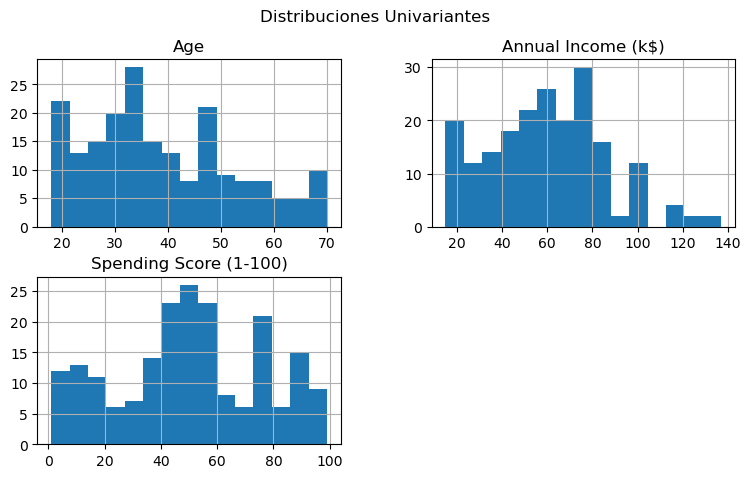

In [8]:
# 3.2 Histograma de variables numéricas
df[['Age','Annual Income (k$)','Spending Score (1-100)']].hist(bins=15, figsize=(9,5));
plt.suptitle('Distribuciones Univariantes')

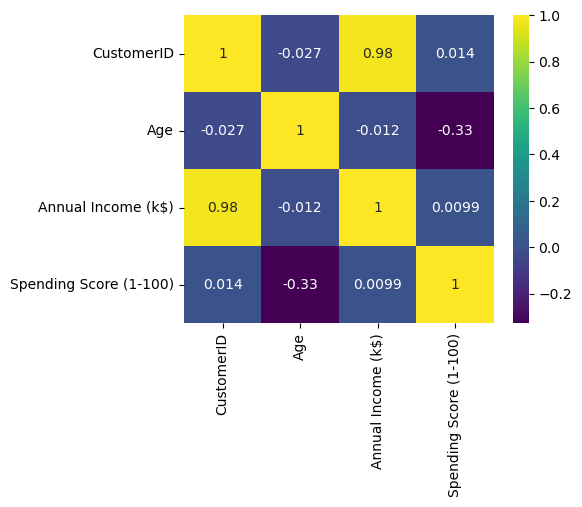

In [9]:
# 3.3 Matriz de correlación
t_corr = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(5,4))
sns.heatmap(t_corr, annot=True, cmap='viridis');

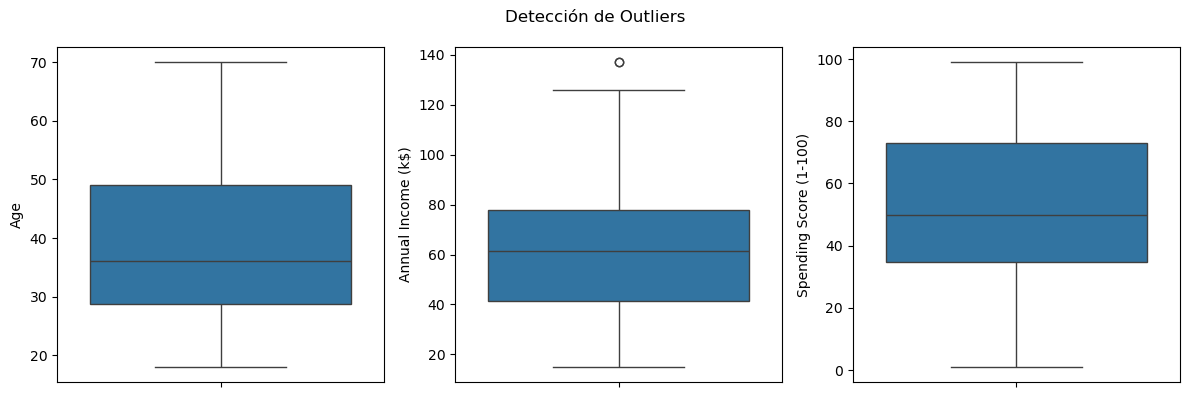

In [10]:
# 3.4 Boxplots para outliers
plt.figure(figsize=(12,4))
for i, col in enumerate(['Age','Annual Income (k$)','Spending Score (1-100)']):
    plt.subplot(1,3,i+1)
    sns.boxplot(y=df[col])
plt.suptitle('Detección de Outliers')
plt.tight_layout()

In [11]:
# 4. Preprocesamiento
df_pre = df.copy()

In [19]:
# 4.2 Codificación de género
ohe = OneHotEncoder(drop='first', sparse_output=False)
gender_encoded = ohe.fit_transform(df_pre[['Gender']])
cols_gender = ohe.get_feature_names_out(['Gender'])
df_gender = pd.DataFrame(gender_encoded, columns=cols_gender)

In [22]:
# 4.3 Construcción del dataset final y escalado
df_model = pd.concat([df_pre.drop(columns=['CustomerID','Gender']), df_gender], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(df_model)

In [23]:
# 5. Selección de Características (SelectKBest)
selector = SelectKBest(score_func=f_classif, k=3)

In [24]:
# Para SelectKBest necesitamos etiquetas dummy; usamos Spending Score en tertiles como etiqueta temporal
y_dummy = pd.qcut(df_pre['Spending Score (1-100)'], q=3, labels=False)
X_sel = selector.fit_transform(X, y_dummy)
selected_features = df_model.columns[selector.get_support()]
print("Características seleccionadas:", list(selected_features))

Características seleccionadas: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']


In [25]:
# 6. Entrenamiento de Hierarchical Clustering
# 6.1 Cálculo de linkage
data_link = linkage(X_sel, method='ward')

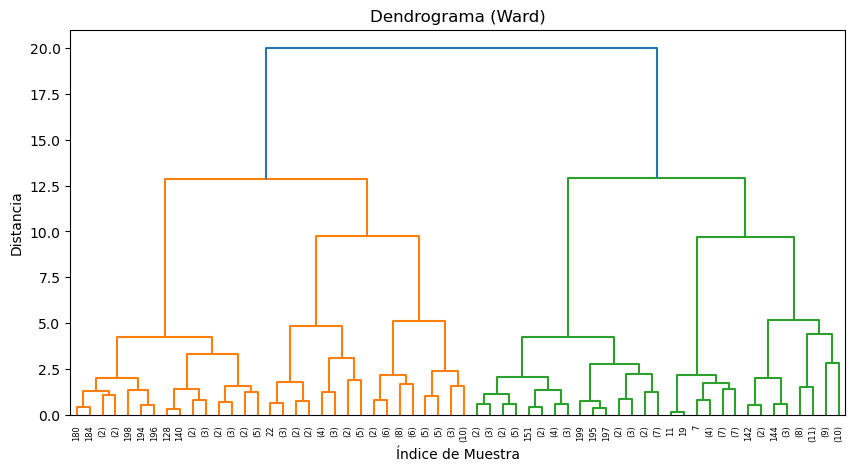

In [26]:
# 6.2 Dendograma para determinar número de clusters
plt.figure(figsize=(10,5))
dendrogram(data_link, truncate_mode='level', p=5)
plt.title('Dendrograma (Ward)')
plt.xlabel('Índice de Muestra')
plt.ylabel('Distancia')
plt.show()

In [37]:
# 6.3 Definir k óptimo manualmente 
k = 5
labels = fcluster(data_link, k, criterion='maxclust')

In [38]:
# 7. Evaluación del modelo
sil = silhouette_score(X_sel, labels)
chi = calinski_harabasz_score(X_sel, labels)
dbi = davies_bouldin_score(X_sel, labels)
print(f"Silhouette Score: {sil:.3f}")
print(f"Calinski-Harabasz Index: {chi:.3f}")
print(f"Davies-Bouldin Index: {dbi:.3f}")

Silhouette Score: 0.390
Calinski-Harabasz Index: 107.827
Davies-Bouldin Index: 0.916


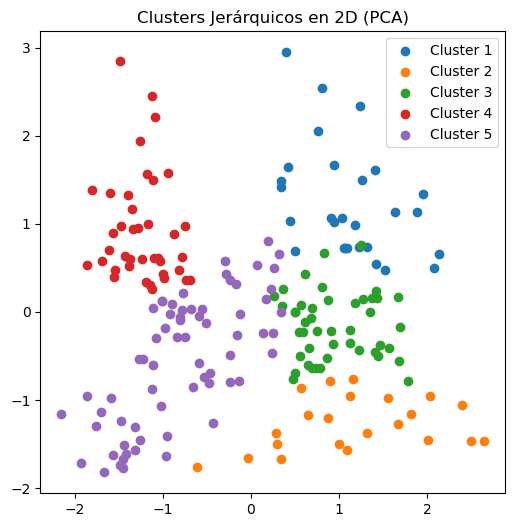

In [39]:
# 8. Visualización de clusters (PCA a 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sel)
plt.figure(figsize=(6,6))
for cl in np.unique(labels):
    plt.scatter(X_pca[labels==cl,0], X_pca[labels==cl,1], label=f'Cluster {cl}')
plt.title('Clusters Jerárquicos en 2D (PCA)')
plt.legend()
plt.show()

In [40]:
# 9. Interpretación de resultados
# Calcular centroides aproximados: media de variables originales por cluster
df_model_sel = pd.DataFrame(X_sel, columns=selected_features)
df_model_sel['Cluster'] = labels
groups = df_model_sel.groupby('Cluster').mean()
print("Centroides aproximados (en características escaladas):")
print(groups)

Centroides aproximados (en características escaladas):
              Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                      
1        0.361909            1.172783               -1.301354
2        0.392433           -1.327810               -1.161823
3        1.259505           -0.201195               -0.071604
4       -0.441917            0.991583                1.239503
5       -0.881969           -0.503698                0.255752
